In [1]:
import numpy as np
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from astropy.io import fits
import astroscrappy

In [3]:
from matplotlib.colors import LogNorm

In [4]:
import scipy.ndimage as ndimage

In [70]:
from extraction_sm import *

Grab one dataset

In [252]:
#sourcefile=("../../datasets/sif_fits/2014-01-03/SIF_PROCESSING_CCD_ROW_1_SM1_OBMT_START_5520130998393550_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2015-04-03/SIF_PROCESSING_CCD_ROW_3_SM1_OBMT_START_45028212999616700_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2015-07-03/SIF_PROCESSING_CCD_ROW_7_SM1_OBMT_START_52953386000234300_CDP_NONE.fits")
sourcefile=("../../datasets/sif_fits/2016-01-29/SIF_PROCESSING_CCD_ROW_3_SM2_OBMT_START_71037995998161500_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2017-07-02/SIF_PROCESSING_CCD_ROW_1_SM2_OBMT_START_116035731998906300_CDP_NONE.fits")
#sourcefile=("../../datasets/sif_fits/2017-09-11/SIF_PROCESSING_CCD_ROW_1_SM1_OBMT_START_122099768999236700_CDP_NONE.fits")

# LMC
#sourcefile=("../../datasets/sif_fits/2016-07-27/SIF_PROCESSING_CCD_ROW_6_SM2_OBMT_START_86607646999502300_CDP_NONE.fits")
# Galaxy
#sourcefile=("../../datasets/sif_fits/2014-12-25/SIF_PROCESSING_CCD_ROW_5_SM1_OBMT_START_36489817999936700_CDP_NONE.fits")
# Jupiter (bright!)
#sourcefile=("../../datasets/sif_fits/2014-11-21/SIF_PROCESSING_CCD_ROW_7_SM1_OBMT_START_33618388000607900_CDP_NONE.fits")


(source,gain,bias,readnoise) = sm_get_image(sourcefile, "../../datasets/sm_bias/sm_calibdat.fits")

(2541, 990)


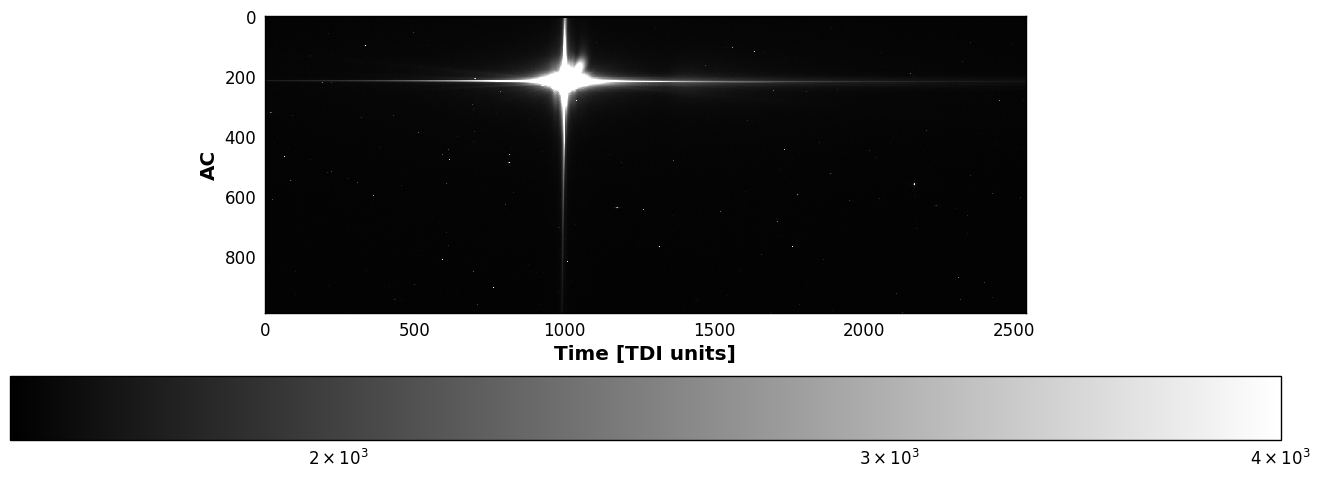

In [253]:
print(source.shape)

image=np.flip(np.rot90(source,1),0) # this should follow the normal gaia convention
plt.xlabel('Time [TDI units]')
plt.ylabel('AC')
plt.imshow(image, cmap='gray', norm=LogNorm(),vmax=4e3)
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(30.5, 5.5)
plt.grid(False)

In [254]:
def sm_starmask(image, threshold):
    """
    Construct a mask for all saturated stars in the SM image.

    This constructs a map of pixels above threshold, labels all connected pixels as one object, using only objects that contain at least one saturated pixel (i.e. above 65535 ADU).
    It then computes the PSF center of the given slices by analyzing the PSF and masks all pixels connected to that center.
    """
    import numpy as np
    from scipy.ndimage import generate_binary_structure
    from scipy.ndimage.morphology import binary_dilation
    from scipy.ndimage.measurements import label, find_objects

    # get the extent of the image
    ymax, xmax = image.shape
    ymax -= 1
    xmax -= 1

    # initialize the mask to all False
    starmask = np.zeros(image.shape, dtype=bool)
   
    # if nothing is saturated, return the starmask
    if np.max(image)<65535:
        return starmask
    else:
        # mask of pixels above threshold
        satmap = np.logical_and(image,image>=threshold)

        # dilate it - sometimes, pixel values fluctuate around the threshold
        satmap = binary_dilation(satmap,iterations=1)

        # labelling all connected pixels
        (starlabels, nstars) = label(satmap,structure=(np.ones((3,3))))

        # object extraction based on labels
        stars = find_objects(starlabels)

        # only use all "stars" that have at least one sample above 65535
        stars = [s for s in stars if np.max(image[s])==65535]
    

    # extract central points of stars and add them to the mask 
    for star in stars:
        # bounding box of coordinates
        y0 = star[0].start
        y1 = np.min([star[0].stop,ymax])
        x0 = star[1].start
        x1 = np.min([star[1].stop,xmax])
        
        # center of psf, using its "wings" as a crosshair:
        cy = int((np.argmax(image[y0:y1,x0]) + np.argmax(image[y0:y1,x1]))/2.) + y0
        cx = int((np.argmax(image[y0,x0:x1]) + np.argmax(image[y1,x0:x1]))/2.) + x0
                
        print(cx,cy)
        # label for the center
        clabel = starlabels[cy,cx]
        
        # THIS region needs to be masked
        starmask[starlabels==clabel] = 1
    
    #return starmask - dilate it once (we won't be losing much here)
    return binary_dilation(starmask,iterations=1)



217 808
Masked  2.14% of pixels


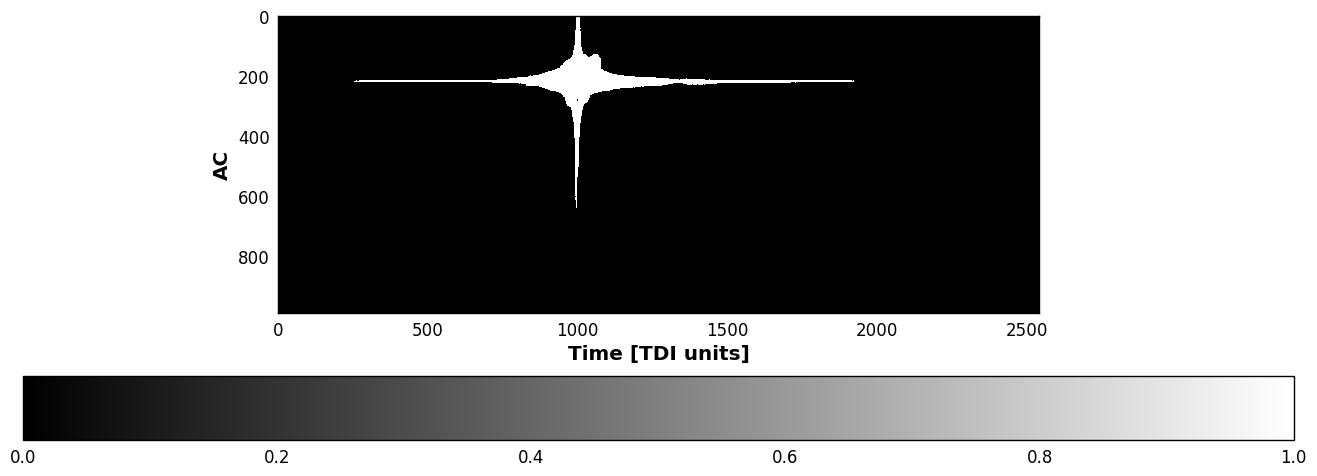

In [255]:
starmask = sm_starmask(source, 2000)

# out of curiosity:
print("Masked {:5.2f}% of pixels".format(100*np.sum(starmask)/source.shape[0]/source.shape[1]))

#image=np.flip(np.rot90(source*(1-starmask),1),0) # this should follow the normal gaia convention
#plt.imshow(image, cmap='gray', norm=LogNorm(),vmin=1000)
image=np.flip(np.rot90(starmask,1),0) # this should follow the normal gaia convention
plt.imshow(image, cmap='gray')
plt.xlabel('Time [TDI units]')
plt.ylabel('AC')
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(30.5, 5.5)
plt.grid(False)

In [246]:
from scipy.ndimage.measurements import label, find_objects
    
imbias = np.subtract(source, bias)

# apply scrappy
(mask,clean) = astroscrappy.detect_cosmics(imbias, gain=gain, verbose=True, inmask=starmask, 
                                           satlevel=65535, readnoise=readnoise, sepmed=False, 
                                           cleantype='meanmask', fsmode='median',
                                           sigclip=10, sigfrac=0.3, objlim=10.0)
# labelling
(labels, ntracks) = label(mask, structure=(np.ones((3,3))))

# object extraction
evtlocs = find_objects(labels)

# calculate the cosmis
cosmics = ((imbias)*gain - clean)*mask

Starting 4 L.A.Cosmic iterations
Iteration 1:
775 cosmic pixels this iteration
Iteration 2:
16 cosmic pixels this iteration
Iteration 3:
2 cosmic pixels this iteration
Iteration 4:
2 cosmic pixels this iteration


-422.695417404 191995.568165


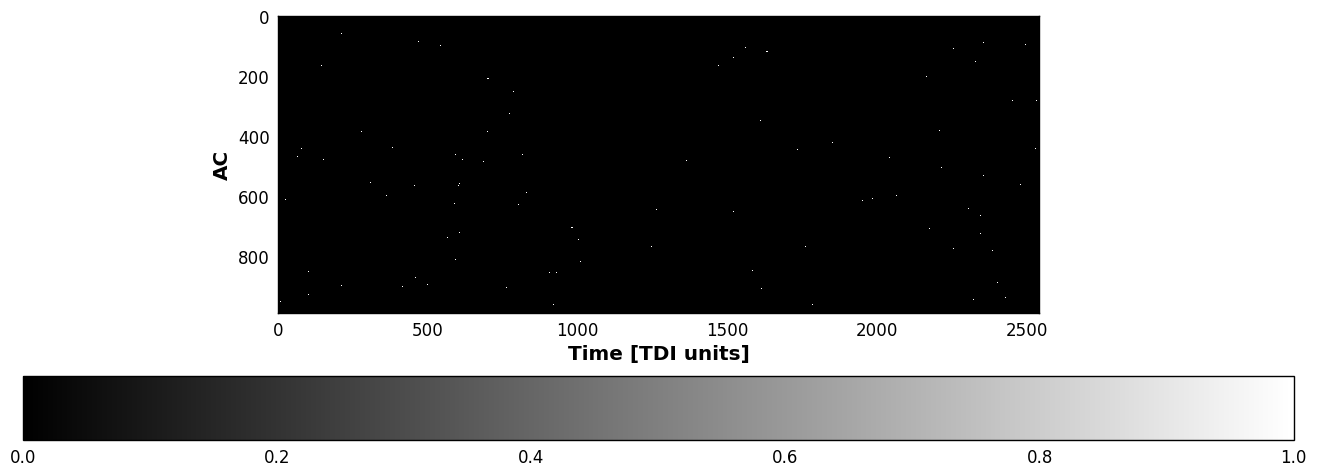

In [247]:
image=np.copy(np.flip(np.rot90(cosmics,1),0)) # this should follow the normal gaia convention
plt.xlabel('Time [TDI units]')
plt.ylabel('AC')

# the mask
image[image>0]=1
image[image<0]=0

plt.imshow(image, cmap='gray')
plt.colorbar(orientation="horizontal")
plt.gcf().set_size_inches(30.5, 5.5)

plt.grid(False)

print(np.min(cosmics), np.max(cosmics))

This star is so bright that there are still fake detecions in its diffraction spikes. How do we fix this?

In [248]:
source = np.subtract(source,bias)*gain

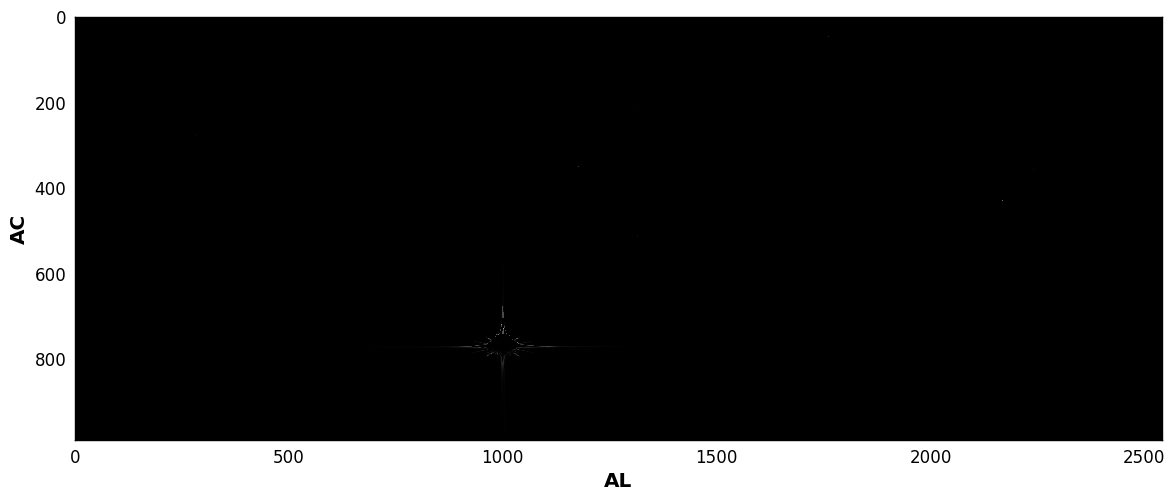

In [249]:
# Laplacian filter

lp = astroscrappy.subsample((source).astype("float32"))
lp = astroscrappy.laplaceconvolve(lp)
lp [lp<0] = 0      # clipping
lp = astroscrappy.rebin(lp)

image=np.rot90(lp,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.gcf().set_size_inches(30.5, 5.5)
plt.imshow(image, cmap='gray')
plt.grid(False)

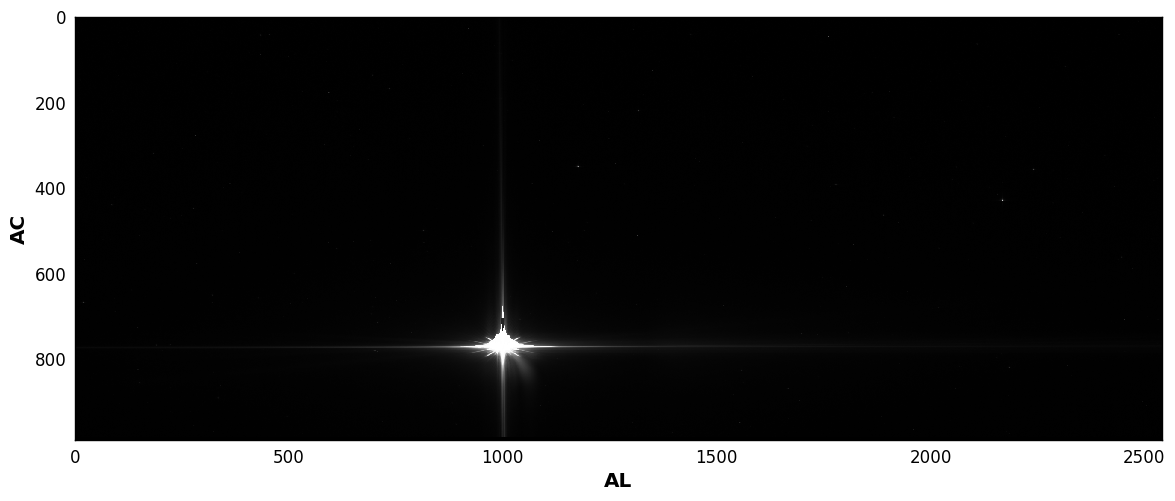

In [38]:
noise = np.sqrt(np.abs(source) + readnoise*readnoise)

image=np.rot90(noise,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.gcf().set_size_inches(30.5, 5.5)
plt.imshow(image, cmap='gray')
plt.grid(False)

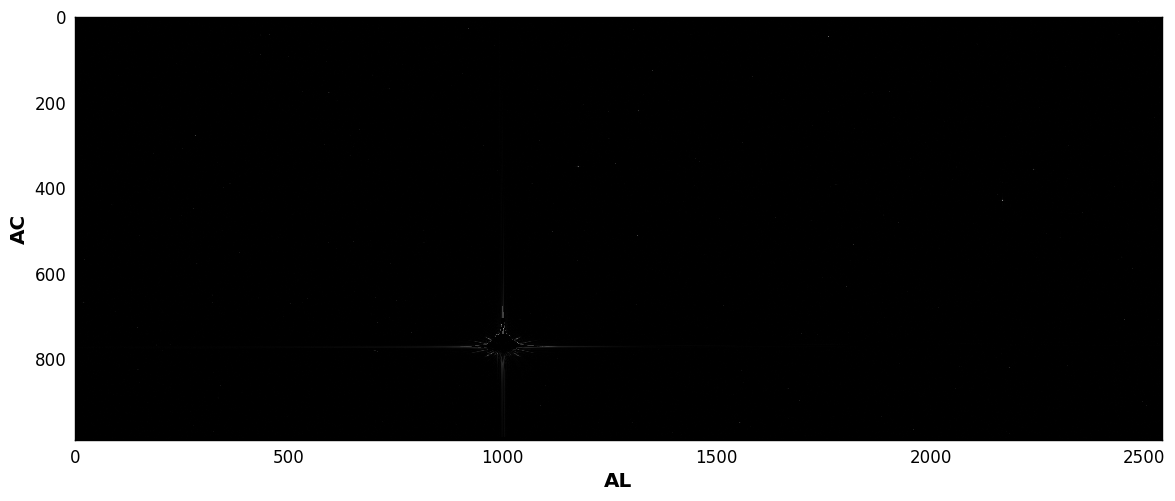

In [41]:
# weigh by noise

S = lp/2/noise

image=np.rot90(S,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.gcf().set_size_inches(30.5, 5.5)
plt.imshow(image, cmap='gray')
#plt.colorbar(orientation="horizontal")
plt.grid(False)

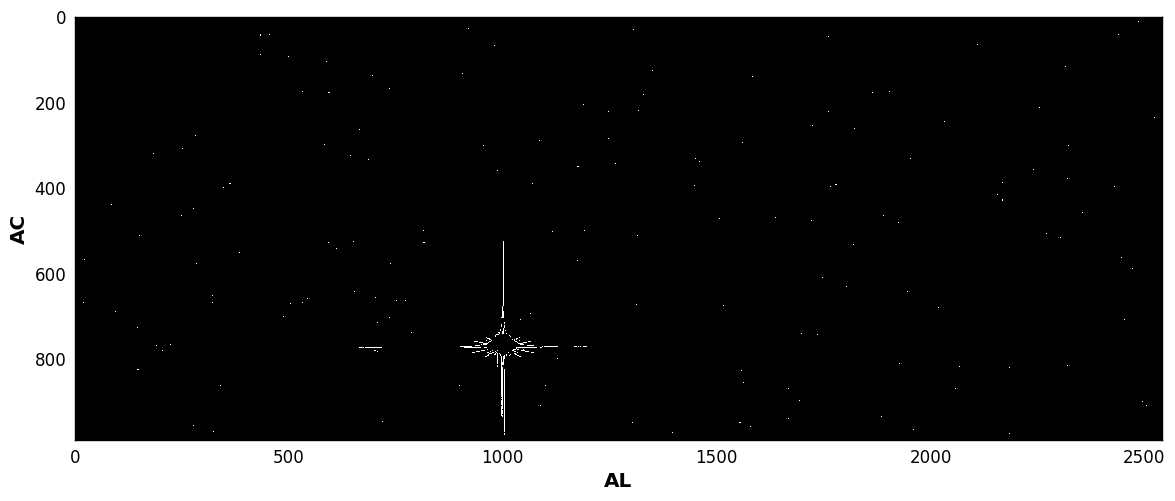

In [40]:
# remove sampling flux - this is now the first criterion

Sp = S - astroscrappy.medfilt5(S.astype("float32"))

# for now, let's just use S though - I don't expect any stars here
stest = np.copy(S)
sigclip = 10

stest[Sp<sigclip] = 0
stest[Sp>=sigclip] = 1


image=np.rot90(stest,1)
plt.xlabel('AL')
plt.ylabel('AC')
plt.gcf().set_size_inches(30.5, 5.5)
plt.imshow(image, cmap='gray')
#plt.colorbar(orientation="horizontal")
plt.grid(False)

So, the problem is that the AC-spikes are not removed by the sampling flux removal - presumably because they are too narrow.